In [62]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import csv
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from collections import Counter 
import string
from nltk.tokenize import word_tokenize
from langdetect import detect
nltk.download("vader_lexicon")
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import stats
import statsmodels.api
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/merlekuehlenborg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [63]:
#Loading the dataset
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

df_trustpilot = pd.read_csv('data/data_trustpilot_first.csv', engine='python')

#Displaying basic information
print(df_trustpilot.columns)
print(df_trustpilot.info())
display(df_trustpilot.head())


Index(['username', 'number_reviews', 'location', 'rating', 'text',
       'date_posted', 'date_of_experience', 'verification', 'subject',
       'answer', 'company'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125346 entries, 0 to 125345
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   username            125340 non-null  object
 1   number_reviews      125346 non-null  int64 
 2   location            125346 non-null  object
 3   rating              125346 non-null  int64 
 4   text                125346 non-null  object
 5   date_posted         125346 non-null  object
 6   date_of_experience  125346 non-null  object
 7   verification        125346 non-null  object
 8   subject             125346 non-null  object
 9   answer              125346 non-null  object
 10  company             125346 non-null  object
dtypes: int64(2), object(9)
memory usage: 10.5+ MB
None


,username,number_reviews,location,rating,text,date_posted,date_of_experience,verification,subject,answer,company
0,Dest Iny,7,GB,5,"ST2 9AL Had an issue with the scan, an employe...",2024-11-15 11:42:09,2024-11-11,Not Verified,ST2 9AL,0,Asda
1,Paula Gray,4,GB,1,Your call centre staff are not the most helpfu...,2024-11-13 18:26:52,2024-11-13,Not Verified,Your call centre staff are not the most…,0,Asda
2,Neil Dodds,4,GB,1,"Just received my order from asda accrington, ...",2024-11-14 21:20:00,2024-11-14,Not Verified,Just received my order from asda…,0,Asda
3,Julie Currey,5,GB,1,"Just had an online home delivery dropped off, ...",2024-11-13 23:34:32,2024-11-13,Not Verified,"Asda, where did it all go wrong?",0,Asda
4,Jessiejames,3,GB,2,Used the Asda rewards app to save for Christma...,2024-11-10 22:10:35,2024-10-01,Not Verified,Rewards not worth it,0,Asda


In [64]:
#Remove non-EN content

stop_words = set(stopwords.words('english'))
company_words = {'flashby', 'asda', 'steelseries', 'quicken'}
stop_words.update(company_words)

# Function to check if text is English
def is_english(text):
   try:
       if isinstance(text, str) and text.strip():
           return detect(text) == 'en'
       return False
   except:
       return False

# Remove non-English content from both text and subject columns
df_trustpilot['text_is_english'] = df_trustpilot['text'].apply(is_english)
df_trustpilot['subject_is_english'] = df_trustpilot['subject'].apply(is_english)

# Keep only rows where both text and subject are in English
df_trustpilot = df_trustpilot[df_trustpilot['text_is_english'] & df_trustpilot['subject_is_english']]
print("Number of rows after removing non-English content:", len(df_trustpilot))
df_trustpilot = df_trustpilot.drop(['text_is_english', 'subject_is_english'], axis=1)


Number of rows after removing non-English content: 100621


STAGE 1 - CREATING NEW COLUMNS

In [65]:
#convert date_posted and date_of_experience to datetime
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])

#Create local_hour and local_date_posted
#Fixing the date_posted column
#The date_posted is from the CET timezone, however, there are countries in the list that are in a different timezone.
#That way, if someone posts at 9 pm in New York City, it appears as 3 am CET, potentially skewing the data.
#We need to fix this column so that date_posted represents the original date and time posted, from the view of the user writing the review.
#Maps the timezone difference from the view of the CET timezone

timezone_offsets = {
    'DE': 0, 'FR': 0, 'IT': 0, 'ES': 0, 'NL': 0, 'BE': 0, 'AT': 0, 'CH': 0, 'SE': 0,
    'DK': 0, 'NO': 0, 'PL': 0, 'CZ': 0, 'PT': 0, 'HU': 0, 'SK': 0, 'SI': 0, 'LU': 0,
    'MT': 0, 'HR': 0, 'BA': 0, 'AL': 0, 'ME': 0, 'RS': 0, 'MK': 0, 'AD': 0, 'LI': 0,
    'FI': 1, 'EE': 1, 'LV': 1, 'LT': 1, 'UA': 1, 'RO': 1, 'BG': 1, 'GR': 1, 'BY': 1,
    'MD': 1, 'TR': 1, 'CY': 1,
    'GB': -1, 'IE': -1, 'IM': -1, 'JE': -1, 'GG': -1, 'GI': -1,
    'RU': 3, 'KZ': 4, 'UZ': 5, 'KG': 5,
    'US': -7, 'CA': -7, 'MX': -7, 'PR': -6, 'VI': -6, 'GU': 10, 'GL': -3,
    'GT': -8, 'HN': -8, 'SV': -8, 'NI': -8, 'CR': -8, 'PA': -7,
    'BS': -7, 'CU': -7, 'JM': -7, 'DO': -6, 'BB': -6, 'TT': -6,
    'KN': -6, 'AG': -6, 'VC': -6, 'AI': -6, 'BM': -6, 'KY': -6,
    'TC': -6, 'AW': -6, 'CW': -6, 'BQ': -6, 'SX': -6, 'GP': -6,
    'BR': -5, 'AR': -5, 'CL': -6, 'CO': -7, 'VE': -6, 'PE': -7,
    'EC': -7, 'BO': -6, 'PY': -6, 'UY': -5,
    'CN': 7, 'JP': 8, 'KR': 8, 'TW': 7, 'MN': 7, 'HK': 7, 'MO': 7,
    'SG': 7, 'MY': 7, 'ID': 7, 'TH': 7, 'VN': 7, 'PH': 7,
    'MM': 6.5, 'KH': 7, 'BN': 7,
    'IN': 4.5, 'PK': 4, 'BD': 5, 'NP': 4.75, 'LK': 4.5, 'MV': 4,
    'AE': 3, 'SA': 2, 'IL': 2, 'IR': 2.5, 'IQ': 2, 'OM': 3,
    'KW': 2, 'QA': 2, 'BH': 2, 'JO': 2, 'LB': 2, 'AF': 3.5,
    'AM': 3, 'AZ': 3, 'GE': 3,
    'AU': 9, 'NZ': 11, 'FJ': 11, 'PF': 10, 'MP': 9,
    'ZA': 1, 'EG': 1, 'MA': 0, 'DZ': 0, 'TN': 0, 'LY': 1,
    'NG': 0, 'GH': 0, 'KE': 2, 'UG': 2, 'RW': 1, 'CD': 1,
    'GA': 0, 'CM': 0, 'ZW': 1, 'CI': 0, 'SS': 2,
    'RE': 3,
    'IS': -1, 'FO': -1, 'AX': 1,
    'XK': 0,
    'VG': -6, 'BZ': -7, 'SC': 3, 'BF': 0, 'MZ': 1, 'ET': 2,
    'SO': 2, 'SZ': 1, 'MC': 0, 'MU': 3, 'PS': 2, 'NC': 10,
    'MH': 11, 'BI': 1, 'PG': 9, 'ZM': 1, 'HT': -6, 'AO': 0,
    'TJ': 4, 'CG': 0, 'GY': -5, 'SN': 0}

countries_in_df = df_trustpilot['location'].unique()
countries_in_mapping = set(timezone_offsets.keys())
missing_countries = set(countries_in_df) - countries_in_mapping
if len(missing_countries) > 0:
    print("Countries in dataset but not in timezone mapping:")
    print(missing_countries)
    print(f"Total missing countries: {len(missing_countries)}")
else:
    print("All countries in the dataset are covered in our timezone mapping!")

def adjust_to_local_time(df_trustpilot):
    df_trustpilot['local_hour'] = 0
    df_trustpilot['local_date_posted'] = None
    for country_code, offset in timezone_offsets.items():
        mask = df_trustpilot['location'] == country_code
        if offset != 0:  
            local_datetime = pd.to_datetime(df_trustpilot.loc[mask, 'date_posted']) + pd.Timedelta(hours=offset)
            df_trustpilot.loc[mask, 'local_date_posted'] = local_datetime.dt.date
            df_trustpilot.loc[mask, 'local_hour'] = local_datetime.dt.hour
    
    cet_mask = df_trustpilot['location'].isin([k for k, v in timezone_offsets.items() if v == 0])
    cet_datetime = pd.to_datetime(df_trustpilot.loc[cet_mask, 'date_posted'])
    df_trustpilot.loc[cet_mask, 'local_date_posted'] = cet_datetime.dt.date
    df_trustpilot.loc[cet_mask, 'local_hour'] = cet_datetime.dt.hour
    
    def evaluate_timezone_adjustment():
        null_local_hour = df_trustpilot['local_hour'].isnull().sum()
        null_local_date = df_trustpilot['local_date_posted'].isnull().sum()
        invalid_hours = df_trustpilot[~df_trustpilot['local_hour'].between(0, 23)].shape[0]
        date_changes = (df_trustpilot['local_date_posted'] != 
                       pd.to_datetime(df_trustpilot['date_posted']).dt.date).sum()
        print("Evaluation Results:")
        print(f"Missing local hours: {null_local_hour}")
        print(f"Missing local dates: {null_local_date}")
        print(f"Invalid hours (not 0-23): {invalid_hours}")
        print(f"Number of date changes due to timezone adjustment: {date_changes}")
        if date_changes > 0:
            print("Sample of records where date changed:")
            date_change_mask = (df_trustpilot['local_date_posted'] != 
                              pd.to_datetime(df_trustpilot['date_posted']).dt.date)
            sample_changes = df_trustpilot[date_change_mask].sample(min(5, date_changes))
            print(sample_changes[['location', 'date_posted', 'local_date_posted', 'local_hour']].to_string())
    evaluate_timezone_adjustment()

    return df_trustpilot

df_trustpilot = adjust_to_local_time(df_trustpilot)
df_trustpilot['local_hour'] = df_trustpilot['local_hour'].astype('int')
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])

All countries in the dataset are covered in our timezone mapping!
Evaluation Results:
Missing local hours: 0
Missing local dates: 0
Invalid hours (not 0-23): 0
Number of date changes due to timezone adjustment: 18484
Sample of records where date changed:
       location         date_posted local_date_posted  local_hour
83193        US 2021-01-28 02:39:34        2021-01-27          19
112126       US 2016-11-18 01:57:30        2016-11-17          18
103738       US 2018-12-22 00:10:38        2018-12-21          17
96953        US 2020-06-30 00:53:30        2020-06-29          17
89947        US 2023-07-16 00:38:11        2023-07-15          17


In [66]:
#Creating days_between_experience_and_post
df_trustpilot['days_between_experience_and_post'] = (df_trustpilot['local_date_posted'] - df_trustpilot['date_of_experience']).dt.days

# Creating day_of_week_posted by extracting day of week (Monday=0, Sunday=6)
df_trustpilot['day_of_week_posted'] = df_trustpilot['local_date_posted'].dt.dayofweek

In [67]:
#Creating columns time_of_day, day_type and month_name

def create_time_features(df):
    def categorize_hour(hour):
        if 5 < hour <= 8:
            return 'Morning'
        elif 9 <= hour <= 17:
            return 'Business Hours'
        elif 18 <= hour <= 22:
            return 'Evening'
        else:
            return 'Night'
    def categorize_day(day):
        if day in [0, 1, 2, 3, 4]:  
            return 'Business Day'
        else:
            return 'Weekend'
    df['time_of_day'] = df['local_hour'].apply(categorize_hour)
    df['day_type'] = df['day_of_week_posted'].apply(categorize_day)
    df['month_name'] = df['local_date_posted'].dt.strftime('%B')
    return df

df_trustpilot = create_time_features(df_trustpilot)

#Printing distributions of new columns
print("Text columns distributions:")
text_columns = ['time_of_day', 'day_type', 'month_name']
for col in text_columns:
    print(f"{col} value counts:")
    print(df_trustpilot[col].value_counts())
print("Numeric columns statistics:")
print("Checking for null values in new columns:")
all_new_columns = text_columns 
print(df_trustpilot[all_new_columns].isnull().sum())

Text columns distributions:
time_of_day value counts:
time_of_day
Business Hours    55286
Evening           20136
Morning           17177
Night              8022
Name: count, dtype: int64
day_type value counts:
day_type
Business Day    76747
Weekend         23874
Name: count, dtype: int64
month_name value counts:
month_name
December     12572
March        10105
April        10038
May           9654
February      9370
January       9369
November      7690
June          7268
October       6758
July          6537
August        6030
September     5230
Name: count, dtype: int64
Numeric columns statistics:
Checking for null values in new columns:
time_of_day    0
day_type       0
month_name     0
dtype: int64


In [68]:
print(df_trustpilot.columns)
display(df_trustpilot.head())

Index(['username', 'number_reviews', 'location', 'rating', 'text',
       'date_posted', 'date_of_experience', 'verification', 'subject',
       'answer', 'company', 'local_hour', 'local_date_posted',
       'days_between_experience_and_post', 'day_of_week_posted', 'time_of_day',
       'day_type', 'month_name'],
      dtype='object')


,username,number_reviews,location,rating,text,date_posted,date_of_experience,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,month_name
0,Dest Iny,7,GB,5,"ST2 9AL Had an issue with the scan, an employe...",2024-11-15 11:42:09,2024-11-11,Not Verified,ST2 9AL,0,Asda,10,2024-11-15,4,4,Business Hours,Business Day,November
1,Paula Gray,4,GB,1,Your call centre staff are not the most helpfu...,2024-11-13 18:26:52,2024-11-13,Not Verified,Your call centre staff are not the most…,0,Asda,17,2024-11-13,0,2,Business Hours,Business Day,November
2,Neil Dodds,4,GB,1,"Just received my order from asda accrington, ...",2024-11-14 21:20:00,2024-11-14,Not Verified,Just received my order from asda…,0,Asda,20,2024-11-14,0,3,Evening,Business Day,November
3,Julie Currey,5,GB,1,"Just had an online home delivery dropped off, ...",2024-11-13 23:34:32,2024-11-13,Not Verified,"Asda, where did it all go wrong?",0,Asda,22,2024-11-13,0,2,Evening,Business Day,November
4,Jessiejames,3,GB,2,Used the Asda rewards app to save for Christma...,2024-11-10 22:10:35,2024-10-01,Not Verified,Rewards not worth it,0,Asda,21,2024-11-10,40,6,Evening,Weekend,November


In [69]:
# Binary encoding for answer presence
# 0 = no answer provided
# 1 = answer provided 

df_trustpilot['answered_encoded'] = np.where(df_trustpilot['answer'] == '0', 0, 1).astype('int')

display(df_trustpilot.head())


,username,number_reviews,location,rating,text,date_posted,date_of_experience,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,month_name,answered_encoded
0,Dest Iny,7,GB,5,"ST2 9AL Had an issue with the scan, an employe...",2024-11-15 11:42:09,2024-11-11,Not Verified,ST2 9AL,0,Asda,10,2024-11-15,4,4,Business Hours,Business Day,November,0
1,Paula Gray,4,GB,1,Your call centre staff are not the most helpfu...,2024-11-13 18:26:52,2024-11-13,Not Verified,Your call centre staff are not the most…,0,Asda,17,2024-11-13,0,2,Business Hours,Business Day,November,0
2,Neil Dodds,4,GB,1,"Just received my order from asda accrington, ...",2024-11-14 21:20:00,2024-11-14,Not Verified,Just received my order from asda…,0,Asda,20,2024-11-14,0,3,Evening,Business Day,November,0
3,Julie Currey,5,GB,1,"Just had an online home delivery dropped off, ...",2024-11-13 23:34:32,2024-11-13,Not Verified,"Asda, where did it all go wrong?",0,Asda,22,2024-11-13,0,2,Evening,Business Day,November,0
4,Jessiejames,3,GB,2,Used the Asda rewards app to save for Christma...,2024-11-10 22:10:35,2024-10-01,Not Verified,Rewards not worth it,0,Asda,21,2024-11-10,40,6,Evening,Weekend,November,0


In [70]:
# Calculate and display distribution statistics
total_users = len(df_trustpilot)
repeat = (df_trustpilot['number_reviews'] >= 2).sum()
pct_repeat = (repeat / total_users) * 100
onetime = (df_trustpilot['number_reviews'] < 2).sum()
pct_onetime = (onetime / total_users) * 100
print("Percentage of users with >= 2 reviews: ", pct_repeat)
print("Percentage of users with < 2 reviews: ", pct_onetime)

# Create categorical column for visualization/EDA
df_trustpilot['repeat_reviewer'] = np.where(df_trustpilot['number_reviews'] >= 2, 'repeat', 'one-time')

# Binary encode for modeling (0 = one-time, 1 = repeat)
df_trustpilot['repeat_reviewer_encoded'] = (df_trustpilot['number_reviews'] >= 2).astype('int')

display(df_trustpilot.head())

Percentage of users with >= 2 reviews:  45.335466751473355
Percentage of users with < 2 reviews:  54.664533248526645


,username,number_reviews,location,rating,text,date_posted,date_of_experience,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,month_name,answered_encoded,repeat_reviewer,repeat_reviewer_encoded
0,Dest Iny,7,GB,5,"ST2 9AL Had an issue with the scan, an employe...",2024-11-15 11:42:09,2024-11-11,Not Verified,ST2 9AL,0,Asda,10,2024-11-15,4,4,Business Hours,Business Day,November,0,repeat,1
1,Paula Gray,4,GB,1,Your call centre staff are not the most helpfu...,2024-11-13 18:26:52,2024-11-13,Not Verified,Your call centre staff are not the most…,0,Asda,17,2024-11-13,0,2,Business Hours,Business Day,November,0,repeat,1
2,Neil Dodds,4,GB,1,"Just received my order from asda accrington, ...",2024-11-14 21:20:00,2024-11-14,Not Verified,Just received my order from asda…,0,Asda,20,2024-11-14,0,3,Evening,Business Day,November,0,repeat,1
3,Julie Currey,5,GB,1,"Just had an online home delivery dropped off, ...",2024-11-13 23:34:32,2024-11-13,Not Verified,"Asda, where did it all go wrong?",0,Asda,22,2024-11-13,0,2,Evening,Business Day,November,0,repeat,1
4,Jessiejames,3,GB,2,Used the Asda rewards app to save for Christma...,2024-11-10 22:10:35,2024-10-01,Not Verified,Rewards not worth it,0,Asda,21,2024-11-10,40,6,Evening,Weekend,November,0,repeat,1


In [71]:
#Creating a column called review_time from days_between_experience_and_post indicating whether the user did an immediate review (<1) or a late review (>=1)
total_reviews = len(df_trustpilot)
quick = (df_trustpilot['days_between_experience_and_post'] < 1).sum()
pct_quick = (quick / total_reviews) * 100
late = (df_trustpilot['days_between_experience_and_post'] >= 1).sum()
pct_late = (late / total_reviews) * 100
print("Percentage of reviews with < 1 days of experience: ", pct_quick)
print("Percentage of reviews with >= 1 days of experience: ", pct_late)

#Creating the column
df_trustpilot['review_time'] = np.where(df_trustpilot['days_between_experience_and_post'] <1, 'quick_review', 'late_review')

#Encoding review_time
#0 = late_review
#1 = quick_review

df_trustpilot['review_time_encoded'] = (df_trustpilot['days_between_experience_and_post'] < 1).astype('int')





Percentage of reviews with < 1 days of experience:  77.40829449120959
Percentage of reviews with >= 1 days of experience:  22.59170550879041


In [72]:
display(df_trustpilot.head())

,username,number_reviews,location,rating,text,date_posted,date_of_experience,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,month_name,answered_encoded,repeat_reviewer,repeat_reviewer_encoded,review_time,review_time_encoded
0,Dest Iny,7,GB,5,"ST2 9AL Had an issue with the scan, an employe...",2024-11-15 11:42:09,2024-11-11,Not Verified,ST2 9AL,0,Asda,10,2024-11-15,4,4,Business Hours,Business Day,November,0,repeat,1,late_review,0
1,Paula Gray,4,GB,1,Your call centre staff are not the most helpfu...,2024-11-13 18:26:52,2024-11-13,Not Verified,Your call centre staff are not the most…,0,Asda,17,2024-11-13,0,2,Business Hours,Business Day,November,0,repeat,1,quick_review,1
2,Neil Dodds,4,GB,1,"Just received my order from asda accrington, ...",2024-11-14 21:20:00,2024-11-14,Not Verified,Just received my order from asda…,0,Asda,20,2024-11-14,0,3,Evening,Business Day,November,0,repeat,1,quick_review,1
3,Julie Currey,5,GB,1,"Just had an online home delivery dropped off, ...",2024-11-13 23:34:32,2024-11-13,Not Verified,"Asda, where did it all go wrong?",0,Asda,22,2024-11-13,0,2,Evening,Business Day,November,0,repeat,1,quick_review,1
4,Jessiejames,3,GB,2,Used the Asda rewards app to save for Christma...,2024-11-10 22:10:35,2024-10-01,Not Verified,Rewards not worth it,0,Asda,21,2024-11-10,40,6,Evening,Weekend,November,0,repeat,1,late_review,0


In [73]:
df_trustpilot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100621 entries, 0 to 125345
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   username                          100617 non-null  object        
 1   number_reviews                    100621 non-null  int64         
 2   location                          100621 non-null  object        
 3   rating                            100621 non-null  int64         
 4   text                              100621 non-null  object        
 5   date_posted                       100621 non-null  datetime64[ns]
 6   date_of_experience                100621 non-null  datetime64[ns]
 7   verification                      100621 non-null  object        
 8   subject                           100621 non-null  object        
 9   answer                            100621 non-null  object        
 10  company                           100

In [74]:
#Converting month_name

print(df_trustpilot['month_name'].unique())
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df_trustpilot['month_local'] = df_trustpilot['month_name'].map(month_map)
df_trustpilot = df_trustpilot.drop('month_name', axis=1)

#Result: Column 'month_local' now displays the numeric values of the month (e.g. 3 for March)
#Deletes the column month_name as it contains the exact same information as month_local

['November' 'October' 'September' 'August' 'July' 'June' 'May' 'April'
 'March' 'February' 'January' 'December']


STAGE 2 - BASIC TEXT PREPROCESSING

Original number of rows: 100621
Number of reviews containing emails: [nan 'export@munnadyechemindustries.com' 'langfordjw@sbcglobal.net'
 'ptheib@gmail.com' 'HankR60@basicisp.net' 'URBAN.RT@GMAIL.COM'
 'ltbl@juno.com.' 'mygigi89@aol.com' 'cassie10@verizon.net'
 'jdemerchant@bell.net']
Number of reviews containing URLs: [nan]


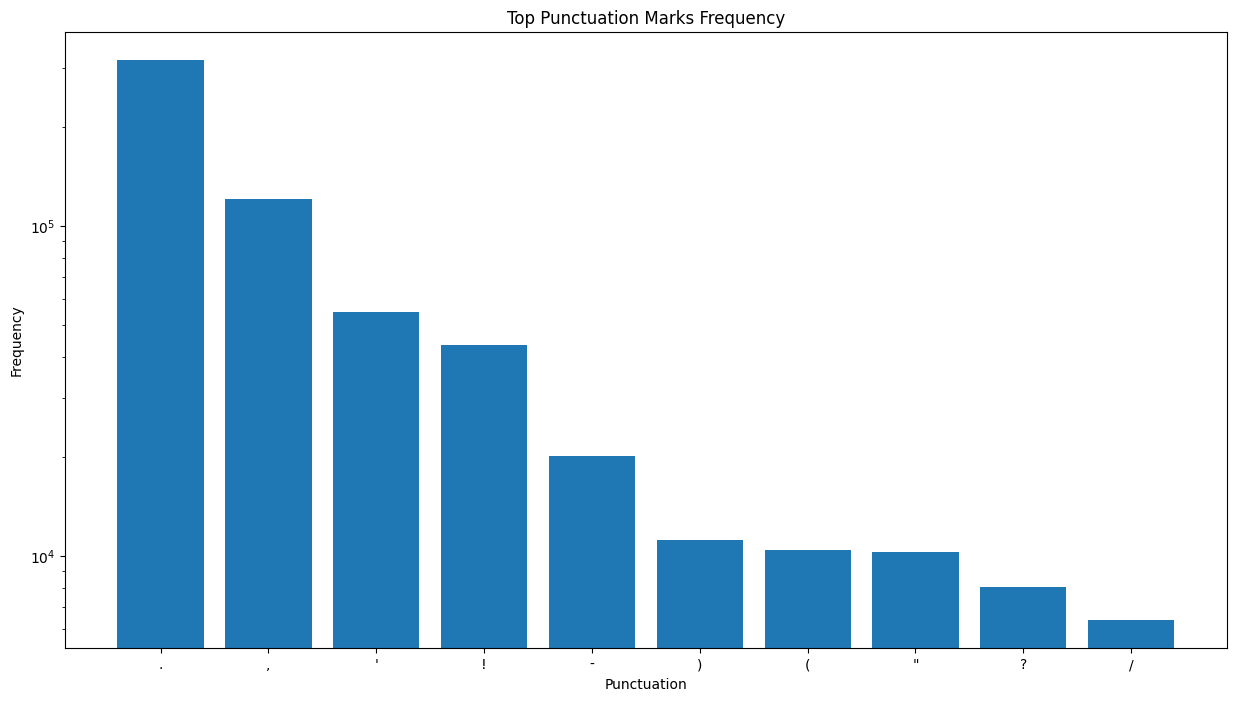

Average character length of text: 169.41 characters
Average character length of subject: 22.81 characters
Average word length of text: 24.87 words
Average word length of subject: 3.43 words
Most common words:
service: 35768
great: 25798
quicken: 24194
customer: 23753
time: 20745
good: 20495
use: 19796
ink: 19592
order: 18937
asda: 18372
would: 17618
get: 17068
one: 16273
product: 14969
delivery: 14548
years: 12885
easy: 12339
like: 12320
controller: 11642
dont: 11456
back: 10968
using: 10898
used: 10778
support: 10278
work: 10177
never: 9817
got: 9727
cartridges: 9351
even: 9130
ive: 9048
still: 8826
price: 8782
company: 8578
im: 8446
money: 8355
ordered: 8284
new: 8215
problem: 8100
received: 7961
could: 7927
fast: 7910
quality: 7751
well: 7543
first: 7264
call: 7257
really: 7217
online: 7160
printer: 7075
help: 7064
need: 7007
days: 6955
2: 6943
phone: 6856
always: 6732
experience: 6683
way: 6650
didnt: 6613
refund: 6563
told: 6521
many: 6514
issue: 6499
also: 6485
account: 6471
inkf

In [75]:
#Basic text preprocessing
print("Original number of rows:", len(df_trustpilot))

#Removing the stop words
stop_words = set(stopwords.words('english'))

# Email extraction
pat_mail = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
df_trustpilot['email'] = df_trustpilot['text'].str.extract(pat_mail, expand=False)

# Check unique emails found
print("Number of reviews containing emails:", df_trustpilot['email'].unique())

# URL extraction
pat_link = r'(https?://(?:www\.)?\w+\.\w{2,}(?:/\S*)?)'
df_trustpilot['link'] = df_trustpilot['text'].str.extract(pat_link, expand=False)

# Check unique links found
print("Number of reviews containing URLs:", df_trustpilot['link'].unique())

# List of punctuation marks to count
punctuation_marks = list(string.punctuation)

# Store punctuation counts in a single column as dictionaries
df_trustpilot['punctuation_counts'] = df_trustpilot['text'].apply(
    lambda x: dict(Counter(c for c in x if c in punctuation_marks))
)

# Aggregate all punctuation counts
all_punctuation_counts = Counter()
df_trustpilot['punctuation_counts'].apply(lambda x: all_punctuation_counts.update(x))

# Visualize the most frequent punctuation marks
top_punctuation = dict(all_punctuation_counts.most_common(10))  # Top 10 most frequent
plt.figure(figsize=(15, 8))
plt.bar(top_punctuation.keys(), top_punctuation.values())
plt.yscale('log')
plt.title("Top Punctuation Marks Frequency")
plt.xlabel("Punctuation")
plt.ylabel("Frequency")
plt.show()

# Function to remove stop words from a given text
def remove_stopwords(text):
    if isinstance(text, str):
        #Convert to lowercase
        text = text.lower()
        #Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', '', text)
        #Properly tokenize the text
        words = word_tokenize(text)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    return text

# Rest of the original code continues as before...
df_trustpilot['text_processed'] = df_trustpilot['text'].apply(remove_stopwords)
df_trustpilot['subject_processed'] = df_trustpilot['subject'].apply(remove_stopwords)
df_trustpilot['answer_processed'] = df_trustpilot['answer'].apply(remove_stopwords)

# Calculate character length for both text and subject columns
df_trustpilot['text_length'] = df_trustpilot['text_processed'].apply(len)
df_trustpilot['subject_length'] = df_trustpilot['subject_processed'].apply(len)
average_length = df_trustpilot['text_length'].mean()
average_subject_length = df_trustpilot['subject_length'].mean()
print(f"Average character length of text: {average_length:.2f} characters")
print(f"Average character length of subject: {average_subject_length:.2f} characters")

# Calculate average word length
df_trustpilot['text_word_length'] = df_trustpilot['text_processed'].apply(lambda x: len(x.split()))
df_trustpilot['subject_word_length'] = df_trustpilot['subject_processed'].apply(lambda x: len(x.split()))
avg_text_words = df_trustpilot['text_word_length'].mean()
avg_subject_words = df_trustpilot['subject_word_length'].mean()
print(f"Average word length of text: {avg_text_words:.2f} words")
print(f"Average word length of subject: {avg_subject_words:.2f} words")

# Combining both text and subject for common words analysis
all_text = ' '.join(df_trustpilot['text_processed']) + ' ' + ' '.join(df_trustpilot['subject_processed'])
# Properly tokenize the combined text
words = word_tokenize(all_text.lower())
# Counting the frequency of each word
word_counts = Counter(words)
# Get the 500 most common words
common_words = word_counts.most_common(500)
# Displaying the common words
print("Most common words:")
for word, count in common_words:
    print(f"{word}: {count}")

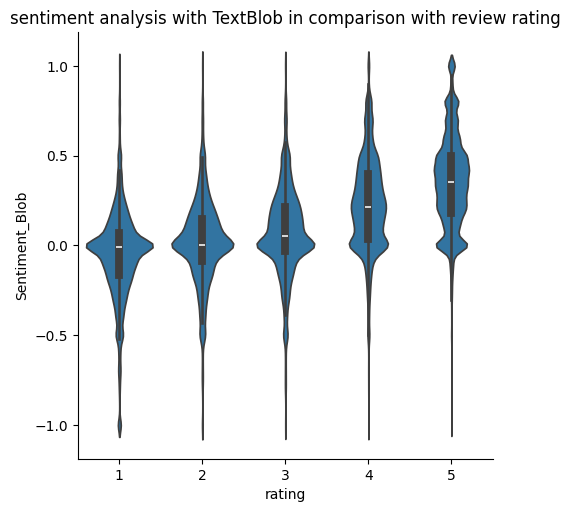

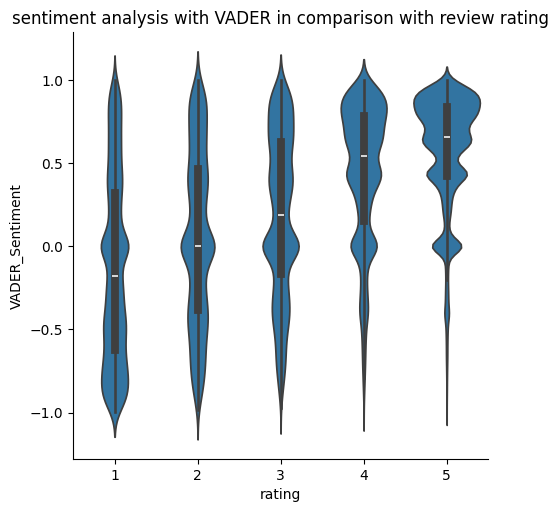

0.20500690710686637
0.4166327108655251


In [76]:
#Basic sentiment scores

#function returning the sentiment calculated by TextBlob
def sentiment_analysis(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
# creating a new column with the sentiment from Text_blob
df_trustpilot['Sentiment_Blob'] = df_trustpilot['text_processed'].apply(lambda text: sentiment_analysis(str(text)))


sns.catplot(x="rating",y="Sentiment_Blob", kind="violin", data=df_trustpilot)
plt.title("sentiment analysis with TextBlob in comparison with review rating")
plt.show();


# Initialise VADER Sentiment-Analyzer
sia = SentimentIntensityAnalyzer()

# Function giving the VADER sentiment back
def vader_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']

# creating new column with VADER_sentiment
df_trustpilot['VADER_Sentiment'] = df_trustpilot['text_processed'].apply(lambda text: vader_sentiment(str(text)))
df_trustpilot.head()

sns.catplot(x="rating",y="VADER_Sentiment", kind="violin", data=df_trustpilot)
plt.title("sentiment analysis with VADER in comparison with review rating")
plt.show();


# creating a new column with categorized values based on the TextBlob Sentiment
df_trustpilot["Sentiment_Blob_cat"]= pd.cut(df_trustpilot["Sentiment_Blob"], bins = [-1, -0.6, -0.2, 0.2, 0.6, 1], labels= [1, 2, 3, 4, 5])
df_trustpilot.head()


# creating a new column with categorized values based on the VADER Sentiment
df_trustpilot["Sentiment_VADER_cat"]= pd.cut(df_trustpilot["VADER_Sentiment"], bins = [-1, -0.6, -0.2, 0.2, 0.6, 1], labels= [1, 2, 3, 4, 5])
df_trustpilot.head()


# creating crosstabs of the actual rating compared to the rating comming from the TextBlob
cm = pd.crosstab(df_trustpilot.rating, df_trustpilot.Sentiment_Blob_cat, rownames = ["Rating"], colnames = ["Sentiment category from TextBlob"])
cm


# calculating true positives for TextBlob
TP_TextBlob = cm.loc[1,1]+cm.loc[2,2]+cm.loc[3,3]+cm.loc[4,4]+cm.loc[5,5]
total_num = df_trustpilot.shape[0]
TP_rate = TP_TextBlob/total_num
print(TP_rate)


# creating crosstabs of the actual rating compared to the rating comming from the VADER
cm = pd.crosstab(df_trustpilot.rating, df_trustpilot.Sentiment_VADER_cat, rownames = ["Rating"], colnames = ["Sentiment category from VADER"])
cm


# calculating true positives for VADER
TP_VADER = cm.loc[1,1]+cm.loc[2,2]+cm.loc[3,3]+cm.loc[4,4]+cm.loc[5,5]
total_num = df_trustpilot.shape[0]
TP_rate = TP_VADER/total_num
print(TP_rate)

Number of words/phrases analyzed: 33
Word frequencies:
poor communication         26
quick turnaround           26
friendly staff             38
prompt response            46
exceeded expectations      51
easy process               57
low quality                58
unresponsive               62
defective product          66
inconvenient               92
dissatisfied              112
terrible service          161
overpriced                177
unprofessional            179
unreliable                193
poor quality              201
poor customer service     212
great quality             249
quality products          254
unhelpful                 299
great experience          349
excellent service         389
disappointing             394
fast delivery             587
frustrating               852
reliable                 1157
helpful                  3932
recommend                3937
quick                    4076
quality                  5350
problem                  6170
support        

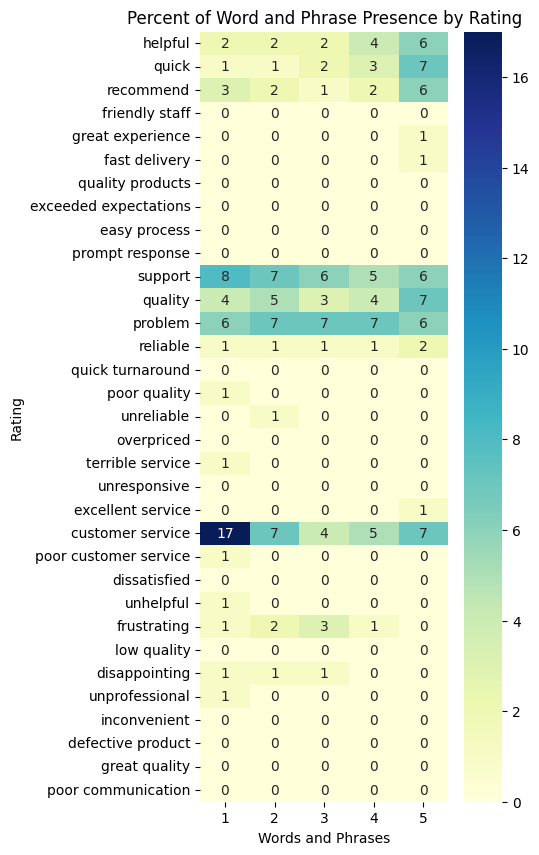

In [77]:
# Creating a list of words and phrases to search in the review test
word_list = ['helpful', 'quick', 'recommend', 'friendly staff', 'great experience', 'fast delivery', 'quality products', 
             'exceeded expectations', 'easy process', 'prompt response', 'support', 'quality', 'problem', 'reliable', 'quick turnaround', 'poor quality', 
             'unreliable', 'overpriced', 'terrible service', 'unresponsive', 'excellent service', 'customer service', 'poor customer service', 
             'dissatisfied', 'unhelpful', 'frustrating', 'low quality', 'disappointing', 'unprofessional', 'inconvenient', 'defective product', 'great quality', 'poor communication']
print("Number of words/phrases analyzed:", len(word_list))

# Create a temporary DataFrame with word occurrences
temp_df = pd.DataFrame()
for word in word_list:
    temp_df[word] = df_trustpilot['text_processed'].str.contains(fr'\b{word}\b', case=False, na=False).astype(int)

# Calculate word frequencies
column_totals = temp_df.sum().sort_values(ascending=True)
print("Word frequencies:")
print(column_totals)

# Group by rating and calculate frequencies
result_df = pd.DataFrame()
for word in word_list:
    result_df[word] = df_trustpilot.groupby('rating')['text_processed'].apply(
        lambda x: x.str.contains(fr'\b{word}\b', case=False, na=False).mean() * 100).round(0)

# Display normalized frequencies
plt.figure(figsize=(4, 10))
sns.heatmap(result_df.T, annot=True, cmap="YlGnBu", fmt='g')  
plt.xlabel("Words and Phrases")
plt.ylabel("Rating")
plt.title("Percent of Word and Phrase Presence by Rating")
plt.show()

In [78]:
#Rearranging the order of the columns
print("Current column order:", df_trustpilot.columns.tolist())

df_trustpilot.rename(columns={'VADER_Sentiment': 'Sentiment_VADER'}, inplace=True)


display(df_trustpilot.head())

df_trustpilot = df_trustpilot[['rating', 'location', 'username', 'number_reviews', 'verification','repeat_reviewer', 'repeat_reviewer_encoded', 'company', 
                               'text', 'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob', 'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat', 
                               'subject', 'subject_processed', 'subject_length', 'subject_word_length', 'answer', 'answer_processed', 'answered_encoded', 
                               'date_of_experience', 'date_posted', 'local_date_posted', 'month_local', 'local_hour', 'time_of_day', 
                               'day_of_week_posted', 'day_type', 'days_between_experience_and_post', 'review_time', 'review_time_encoded']]

Current column order: ['username', 'number_reviews', 'location', 'rating', 'text', 'date_posted', 'date_of_experience', 'verification', 'subject', 'answer', 'company', 'local_hour', 'local_date_posted', 'days_between_experience_and_post', 'day_of_week_posted', 'time_of_day', 'day_type', 'answered_encoded', 'repeat_reviewer', 'repeat_reviewer_encoded', 'review_time', 'review_time_encoded', 'month_local', 'email', 'link', 'punctuation_counts', 'text_processed', 'subject_processed', 'answer_processed', 'text_length', 'subject_length', 'text_word_length', 'subject_word_length', 'Sentiment_Blob', 'VADER_Sentiment', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat']


,username,number_reviews,location,rating,text,date_posted,date_of_experience,verification,subject,answer,company,local_hour,local_date_posted,days_between_experience_and_post,day_of_week_posted,time_of_day,day_type,answered_encoded,repeat_reviewer,repeat_reviewer_encoded,review_time,review_time_encoded,month_local,email,link,punctuation_counts,text_processed,subject_processed,answer_processed,text_length,subject_length,text_word_length,subject_word_length,Sentiment_Blob,Sentiment_VADER,Sentiment_Blob_cat,Sentiment_VADER_cat
0,Dest Iny,7,GB,5,"ST2 9AL Had an issue with the scan, an employe...",2024-11-15 11:42:09,2024-11-11,Not Verified,ST2 9AL,0,Asda,10,2024-11-15,4,4,Business Hours,Business Day,0,repeat,1,late_review,0,11,NaN,NaN,"{',': 5, '.': 5}",st2 9al issue scan employee named rose helped ...,st2 9al,0,215,7,35,2,0.435000,0.8316,4,5
1,Paula Gray,4,GB,1,Your call centre staff are not the most helpfu...,2024-11-13 18:26:52,2024-11-13,Not Verified,Your call centre staff are not the most…,0,Asda,17,2024-11-13,0,2,Business Hours,Business Day,0,repeat,1,quick_review,1,11,NaN,NaN,"{'.': 2, '-': 2, '!': 5}",call centre staff helpful several times tried ...,call centre staff,0,265,17,39,3,-0.228571,-0.5859,2,2
2,Neil Dodds,4,GB,1,"Just received my order from asda accrington, ...",2024-11-14 21:20:00,2024-11-14,Not Verified,Just received my order from asda…,0,Asda,20,2024-11-14,0,3,Evening,Business Day,0,repeat,1,quick_review,1,11,NaN,NaN,"{',': 5, '.': 1}",received order asda accrington ordered 2 rump ...,received order asda,0,236,19,36,3,0.250000,0.4939,4,4
3,Julie Currey,5,GB,1,"Just had an online home delivery dropped off, ...",2024-11-13 23:34:32,2024-11-13,Not Verified,"Asda, where did it all go wrong?",0,Asda,22,2024-11-13,0,2,Evening,Business Day,0,repeat,1,quick_review,1,11,NaN,NaN,"{',': 6, '.': 4, '!': 1}",online home delivery dropped substitutes items...,asda go wrong,0,370,13,56,3,-0.275000,-0.9540,2,1
4,Jessiejames,3,GB,2,Used the Asda rewards app to save for Christma...,2024-11-10 22:10:35,2024-10-01,Not Verified,Rewards not worth it,0,Asda,21,2024-11-10,40,6,Evening,Weekend,0,repeat,1,late_review,0,11,NaN,NaN,"{'.': 1, ',': 1}",used asda rewards app save christmas noticed p...,rewards worth,0,152,13,23,2,-0.033333,0.9071,3,5


In [79]:
#Last check

print(df_trustpilot.columns)
print(df_trustpilot.info())
display(df_trustpilot.head())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 100621 entries, 0 to 125345
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   rating                            100621 non-null  in

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,5,GB,Dest Iny,7,Not Verified,repeat,1,Asda,"ST2 9AL Had an issue with the scan, an employe...",st2 9al issue scan employee named rose helped ...,215,35,0.435000,4,0.8316,5,ST2 9AL,st2 9al,7,2,0,0,0,2024-11-11,2024-11-15 11:42:09,2024-11-15,11,10,Business Hours,4,Business Day,4,late_review,0
1,1,GB,Paula Gray,4,Not Verified,repeat,1,Asda,Your call centre staff are not the most helpfu...,call centre staff helpful several times tried ...,265,39,-0.228571,2,-0.5859,2,Your call centre staff are not the most…,call centre staff,17,3,0,0,0,2024-11-13,2024-11-13 18:26:52,2024-11-13,11,17,Business Hours,2,Business Day,0,quick_review,1
2,1,GB,Neil Dodds,4,Not Verified,repeat,1,Asda,"Just received my order from asda accrington, ...",received order asda accrington ordered 2 rump ...,236,36,0.250000,4,0.4939,4,Just received my order from asda…,received order asda,19,3,0,0,0,2024-11-14,2024-11-14 21:20:00,2024-11-14,11,20,Evening,3,Business Day,0,quick_review,1
3,1,GB,Julie Currey,5,Not Verified,repeat,1,Asda,"Just had an online home delivery dropped off, ...",online home delivery dropped substitutes items...,370,56,-0.275000,2,-0.9540,1,"Asda, where did it all go wrong?",asda go wrong,13,3,0,0,0,2024-11-13,2024-11-13 23:34:32,2024-11-13,11,22,Evening,2,Business Day,0,quick_review,1
4,2,GB,Jessiejames,3,Not Verified,repeat,1,Asda,Used the Asda rewards app to save for Christma...,used asda rewards app save christmas noticed p...,152,23,-0.033333,3,0.9071,5,Rewards not worth it,rewards worth,13,2,0,0,0,2024-10-01,2024-11-10 22:10:35,2024-11-10,11,21,Evening,6,Weekend,40,late_review,0


In [82]:
import os

os.makedirs('data', exist_ok=True)

csv_path = 'data/data_trustpilot.csv.gz'  
df_trustpilot.to_csv(csv_path, index=False, compression='gzip', encoding='utf-8') 
print(f"DataFrame exported to {csv_path}")

DataFrame exported to data/data_trustpilot.csv.gz
